In [1]:
from io import open   #加载必要文件 
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0      #定义Lang类，会分别记录两种语言中的句子和高频词
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.word2count[word] = 1
            self.idx2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Unicode to ASCII                
# Code from https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
MAX_LENGTH = 10           #定义从语料中筛选出适合的语料的方法

eng_prefixes = (          
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [5]:
# Read the data file

def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    for line in lines:
        print(line)

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135829 sentence pairs
Trimmed to 10588 sentence pairs
Counting words...
Counted words:
fra 4341
eng 2800
['il fait profession d avocat .', 'he is a lawyer by profession .']


In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input_, hidden):
        embedded = self.embedding(input_).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)

In [7]:
class DecoderRNN(nn.Module):           #这个例子中没用到这个类型的decoder
    def __init__(self, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # Attention weights
        # Concatenate between embedded input and the previous hidden state
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # bmm means batch matrix matrix product
        # https://pytorch.org/docs/master/torch.html?highlight=bmm#torch.bmm
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        # Combine attention weights
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        # From here on is normal decoder stuff
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
def indexes_from_sentence(lang, sentence):               #把语料转换为tensor，准备训练
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [10]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [11]:
import time            #辅助函数，用于显示已用了多次时间和预测还需多少时间
import math


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [12]:
def train_iters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            

    show_plot(plot_losses)

In [13]:
import matplotlib.pyplot as plt           #用于显示loss
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):       
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [15]:
def evaluate_randomly(encoder, decoder, n=10):         #这是是随机选择10条语句显示模型的预测结果和真实结果，没有计算BLEU
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

4m 25s (- 61m 51s) (5000 6%) 2.8264
8m 34s (- 55m 46s) (10000 13%) 2.2881
12m 40s (- 50m 42s) (15000 20%) 1.9677
16m 49s (- 46m 16s) (20000 26%) 1.7418
20m 59s (- 41m 58s) (25000 33%) 1.5658
25m 6s (- 37m 40s) (30000 40%) 1.3897
29m 19s (- 33m 30s) (35000 46%) 1.2413
33m 31s (- 29m 20s) (40000 53%) 1.0976
37m 45s (- 25m 10s) (45000 60%) 0.9889
41m 57s (- 20m 58s) (50000 66%) 0.8888
46m 12s (- 16m 48s) (55000 73%) 0.8057
50m 26s (- 12m 36s) (60000 80%) 0.7267
54m 39s (- 8m 24s) (65000 86%) 0.6842
58m 54s (- 4m 12s) (70000 93%) 0.5831
63m 7s (- 0m 0s) (75000 100%) 0.5521


<Figure size 432x288 with 0 Axes>

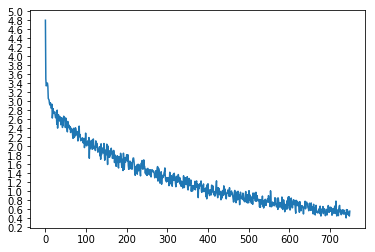

In [16]:
hidden_size = 256                            #定义带attention的rnn模型
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_iters(encoder1, attn_decoder1, 75000, print_every=5000)

In [17]:
evaluate_randomly(encoder1, attn_decoder1)           #随机选取十条句子展示带attention的RNN模型预测结果与真实语料

> il parle vite .
= he is a fast speaker .
< he s a fast speaker . <EOS>

> je suis etudiant a l universite .
= i m a university student .
< i am a student student . <EOS>

> il est assez age pour le comprendre .
= he is old enough to understand it .
< he is old enough for understand . <EOS>

> tu vas me manquer .
= i m going to miss you .
< i m going to miss you . <EOS>

> je suis fiere de mon pere .
= i m proud of my dad .
< i m proud of my father . <EOS>

> je m ennuie en ce moment .
= i m bored right now .
< i m bored right now . <EOS>

> nous sommes affames .
= we re starved .
< we re unlucky . <EOS>

> il a honte de poser des questions .
= he is ashamed to ask questions .
< he s in to the trouble . <EOS>

> je suis de meilleur humeur maintenant .
= i m in a better mood now .
< i m in a better mood now . <EOS>

> je ne suis pas content .
= i am not happy .
< i m not happy . <EOS>



input = elle a cinq ans de moins que moi .
output = she s five years younger than me am . <EOS>


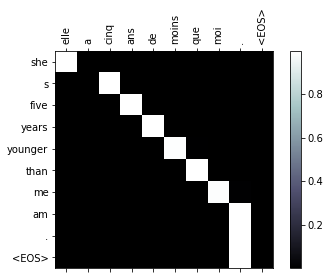

input = elle est trop petit .
output = she s too short . <EOS>


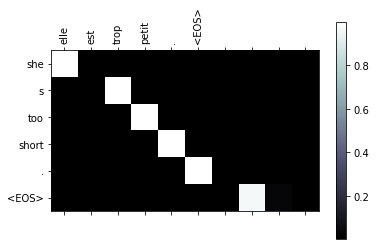

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


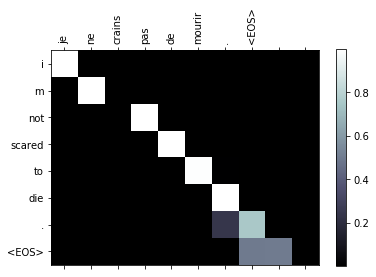

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


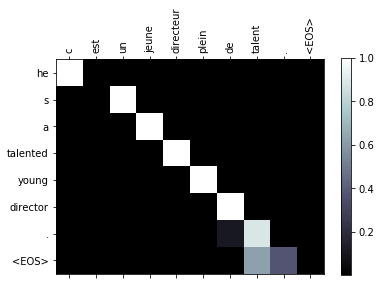

In [19]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")     #展示以下句子在翻译时attention起到的对齐效果

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

4m 24s (- 61m 38s) (5000 6%) 2.8325
8m 39s (- 56m 16s) (10000 13%) 2.2710
12m 43s (- 50m 55s) (15000 20%) 1.9516
16m 50s (- 46m 17s) (20000 26%) 1.6949
20m 56s (- 41m 52s) (25000 33%) 1.5190
25m 7s (- 37m 41s) (30000 40%) 1.3461
29m 24s (- 33m 36s) (35000 46%) 1.2336
33m 45s (- 29m 32s) (40000 53%) 1.0907
37m 57s (- 25m 18s) (45000 60%) 0.9919
42m 8s (- 21m 4s) (50000 66%) 0.9390
46m 23s (- 16m 52s) (55000 73%) 0.8159
50m 36s (- 12m 39s) (60000 80%) 0.7447
54m 48s (- 8m 25s) (65000 86%) 0.7058
59m 3s (- 4m 13s) (70000 93%) 0.6364
63m 18s (- 0m 0s) (75000 100%) 0.5845


<Figure size 432x288 with 0 Axes>

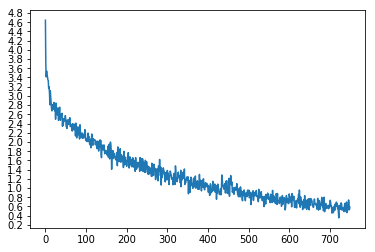

In [20]:
hidden_size = 256                            #定义一个不带attention的模型
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_iters(encoder2, decoder2, 75000, print_every=5000)

In [21]:
evaluate_randomly(encoder2, decoder2)  

> elle est d une humeur massacrante .
= she is in an awful mood .
< she is in an mood mood . <EOS>

> tu es si gentil !
= you re so sweet .
< you re so sweet . <EOS>

> vous n etes pas censee etre la dedans .
= you re not supposed to be in here .
< you re not supposed to be in here . <EOS>

> je ne suis pas content .
= i m not happy .
< i m not happy . <EOS>

> je ne suis pas encore pret .
= i m not ready yet .
< i m not ready yet . <EOS>

> il n est bon a rien .
= he is good for nothing .
< he is good for nothing . <EOS>

> je suis le second de trois enfants .
= i m the middle child of three .
< i am the middle child of three . <EOS>

> elle est francaise .
= she is french .
< she is french . <EOS>

> il est tellement mignon !
= he s so cute .
< he s so cute . <EOS>

> je suis immunise .
= i m immune .
< i m in . . <EOS>

